# EECS 298b ML for Signal Processing
# Lecture 2: Predicting deterministic (but chaotic) timeseries

# Initialization and loading data
These are the basic steps at the start of any project

In [2]:
%tensorflow_version 2.x
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import tensorflow as tf

#Mackey-Glass equation

This is a chaotic timeseries with some approximately periodic structure.  It is difficult to extrapolate due to high sensitivity to initial conditions.  There are several forms; here is the discrete-time version with parameters known to cause chaotic behavior:

\begin{equation}
  x(t+1) = c x(t) + \frac{a x(t-23)}{b + x(t-23)^{10}}
\end{equation}

This is a deterministic series, in the sense that $x(t+1) = f(x(t), x(t-1), \ldots x(t-23))$.  There is no randomness, and so in theory the exact function $\hat{f} = f$ could be learned.  However, because the iteration is chaotic, even for very small errors, the estimate $\hat{x}(t) = \hat{f}(\hat{x}(t-1)\ldots)$ will diverge from $x(t) = f(x(t-1)\ldots)$.  In fact, for arbitrarily small errors $\epsilon$ there will eventually be divergence if $| f - \hat{f} | > \epsilon$.

In general, for a chaotic system we have
\begin{equation}
  | x(t) - \hat{x}(t) | \approx e^{\lambda t} |x(0) - \hat{x}(0)|
  \end{equation}
where $\lambda$ is the ''Lyapunov exponent'' and $\lambda > 0$ means that the error grows exponentially even for arbitrarily small initial errors $\epsilon = x(0) - \hat{x}(0)$.  In fact, the error is not unbounded for the Mackey-Glass equation, because there are many approximate values of $\hat{f}$ that, like $f$ remain bounded so that $|x(t) - \hat{x}(t)| < C$ where $C$ is some large number.  The Lyapunov exponents apply in the neighborhood of small values of $\epsilon$ and indicate that there is approximately exponential early growth of error.

The significance of this is that even though this is deterministic, no machine learning algorithm, no matter how accurate, will ever be able to predict the Mackey-Glass equation (or any chaotic system) for more than a limited number of timesteps.

In [3]:
def mackey_glass(n, a=0.2, b=0.8, c=0.9, d=23, e=10, initial=0.1):
    x = np.zeros(n)
    x[0] = initial
    d = int(d)
    for k in range(0,n-1):
        x[k+1]  = c*x[k] + ( (a*x[k-d]) / (b + ( x[k-d]**e)) )   
    return x

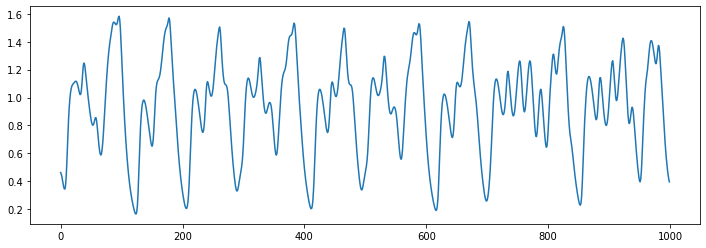

In [4]:
mg = mackey_glass(2000)
mg = mg[1000:]    #after has achieved steady state
plt.figure(figsize=(12,4),linewidth=4)
plt.plot(mg);

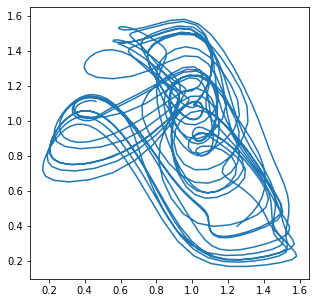

In [5]:
# plot x(t) vs. x(t-23) to see a 2D "embedding" of the chaotic system
plt.figure(figsize=(5,5))
plt.plot(mg[:len(mg)-23],mg[23:]);

In [6]:
#Make a series and dataframe with integer "timestamps"
mgSeries = pd.Series(name='MG', data=mg, index=range(0,len(mg)))
df = mgSeries.to_frame(name="MG")


##Deterministic timeseries predictor

In [7]:
#will attempt to predict the last test_size elements in the series
test_size = 100
test_ind = len(df)-test_size  #index of the first element to predict -1
train=df.iloc[:test_ind]  #train on everything before that
test=df.iloc[test_ind:]   #test on everything after that

In [8]:
#scale the range
from sklearn.preprocessing import MinMaxScaler
scaler = MinMaxScaler()
scaler.fit(train)
scaled_train = scaler.transform(train)
scaled_test = scaler.transform(test)  #scale the test set using the training set scaler 
                                      #(because we don't know the test set beforehand)
                                      #NOTE: scaler.transform() returns a numpy array, even for dataframe input

In [9]:
#create the timeseries data
from tensorflow.keras.preprocessing.sequence import TimeseriesGenerator
predict_length = 25
generator = TimeseriesGenerator(scaled_train, scaled_train, length = predict_length, batch_size=1)
#X,y = generator[t] produces an array {[X(t-N)...X(t-1)], [X(t)]}

In [10]:
#create the network
#from tensorflow.tools.docs.doc_controls import do_not_doc_inheritable
#from matplotlib import use
from tensorflow.python.keras.engine.base_layer_utils import uses_keras_history
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Reshape, Flatten
from tensorflow.keras.layers import LSTM
n_features = 1
model = Sequential()
use_lstm = 0
if use_lstm == 1:
  model.add(LSTM(30, activation='relu', input_shape=(predict_length, n_features)))
  #lstm expects the data generator to supply samples in time sequence
else:
  #if you don't flatten, will get a separate single-input net for each time value
  #don't need to do this for LSTM layers; they flatten implicitly
  model.add(Flatten(input_shape = (predict_length, n_features)))
  model.add(Dense(20, activation = 'relu'))
model.add(Dense(1))
model.compile(optimizer='adam', loss='mse')
model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 flatten (Flatten)           (None, 25)                0         
                                                                 
 dense (Dense)               (None, 20)                520       
                                                                 
 dense_1 (Dense)             (None, 1)                 21        
                                                                 
Total params: 541
Trainable params: 541
Non-trainable params: 0
_________________________________________________________________


In [11]:
from tensorflow.keras.callbacks import EarlyStopping
early_stop = EarlyStopping(monitor='val_loss',patience=2)
validation_generator = TimeseriesGenerator(scaled_test,scaled_test, length=predict_length, batch_size=1)

##To ensure that your homework outputs are your own, please set the random seed for your simulations to be your UCI ID number (or some other number unique to you).

In [12]:
#for all homework, please set the seeds of your random number generators to your UCI ID number
np.random.seed(10327798)
tf.random.set_seed(10327798)

model.fit(generator,epochs=20,
                    validation_data=validation_generator,
                   callbacks=[early_stop])

Epoch 1/20
875/875 [==============================] - 3s 3ms/step - loss: 0.0434 - val_loss: 0.0062
Epoch 2/20
875/875 [==============================] - 2s 3ms/step - loss: 0.0033 - val_loss: 0.0033
Epoch 3/20
875/875 [==============================] - 2s 3ms/step - loss: 0.0016 - val_loss: 0.0012
Epoch 4/20
875/875 [==============================] - 2s 3ms/step - loss: 8.9425e-04 - val_loss: 0.0014
Epoch 5/20
875/875 [==============================] - 2s 3ms/step - loss: 8.4179e-04 - val_loss: 6.3371e-04
Epoch 6/20
875/875 [==============================] - 2s 3ms/step - loss: 9.6282e-04 - val_loss: 6.6405e-04
Epoch 7/20
875/875 [==============================] - 2s 3ms/step - loss: 9.4282e-04 - val_loss: 4.9885e-04
Epoch 8/20
875/875 [==============================] - 2s 2ms/step - loss: 7.4559e-04 - val_loss: 4.3366e-04
Epoch 9/20
875/875 [==============================] - 2s 3ms/step - loss: 6.6376e-04 - val_loss: 4.5607e-04
Epoch 10/20
875/875 [==============================] - 2

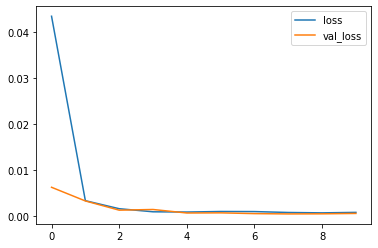

In [13]:
losses = pd.DataFrame(model.history.history)
losses.plot();

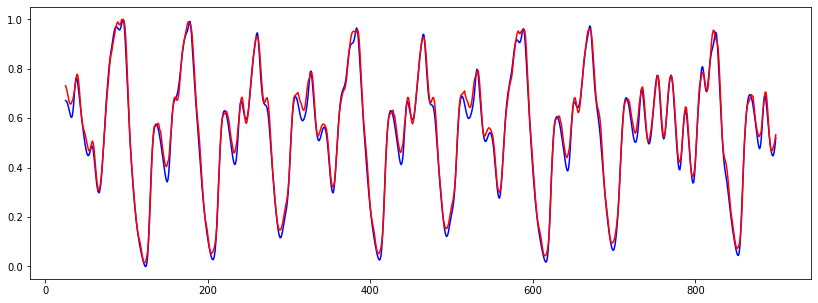

In [14]:
#get the model predictions for all timepoints
predicted_outputs = model.predict(generator)
#convert to dataframes with the correct timestamps.  outputs start at t=predict_length
train_predict = pd.DataFrame(data=predicted_outputs, columns=['eeg'], index=train.index[predict_length:])
train_orig = pd.DataFrame(data=scaled_train[predict_length:], columns=['eeg'], index=train.index[predict_length:len(scaled_train)])
plt.figure(figsize=(14,5),linewidth=1)
ax = plt.gca()
plt.plot(train_orig,'b')
plt.plot(train_predict,'r')
plt.show();

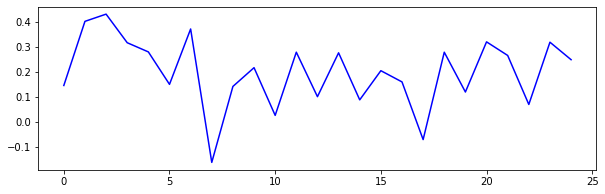

In [15]:
impulse = np.zeros(2*predict_length)
impulse[predict_length]=1
impulse_generator = TimeseriesGenerator(impulse,impulse, length = predict_length, batch_size=1)
impulse_response = model.predict(impulse_generator)
plt.figure(figsize=(10,3),linewidth=1)
plt.plot(impulse_response,'b')
plt.show()

Here we look at the iterated predictions.  This means using $x(t-N) \ldots x(t-1)$ to predict $\hat{x}(t)$, then using $\hat{x}(t)$ to predict $\hat{x}(t+1)$, and so on.  Each time, we can compare to how well we would have done with full knowledge up to that time.

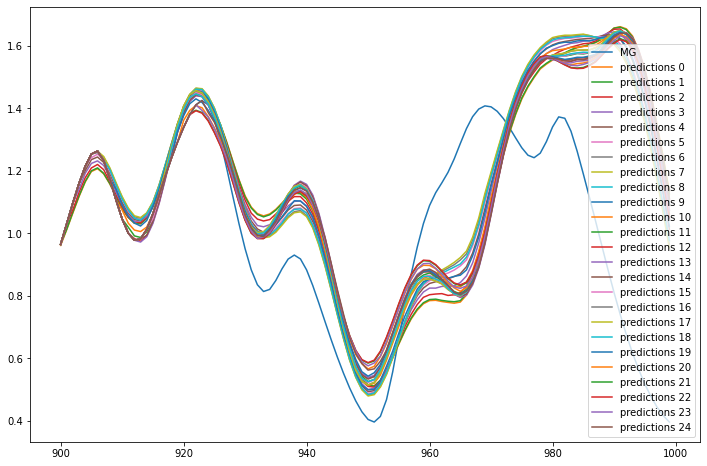

In [16]:
 test_predict = test.copy()
 for t0 in range(predict_length):
  test_predictions = []

  if t0>0:
    first_eval_batch = np.append(scaled_train[-(predict_length-t0):],scaled_test[:t0])
  else:
    first_eval_batch = scaled_train[-predict_length:]
  current_batch = first_eval_batch.reshape((1, predict_length, n_features))

  for i in range(len(test)-t0):
      
      # get prediction 1 time stamp ahead ([0] is for grabbing just the number instead of [array])
      current_pred = model.predict(current_batch)[0]
      
      # store prediction
      test_predictions.append(current_pred) 
      
      # update batch to now include prediction and drop first value
      current_batch = np.append(current_batch[:,1:,:],[[current_pred]],axis=1)

  if t0>0:
    test_predictions = np.append(scaled_test[:t0], test_predictions, axis=0)
  scaled_predictions = scaler.inverse_transform(test_predictions)
  test_predict[f'predictions {t0}']= scaled_predictions
test_predict.plot(figsize=(12,8))

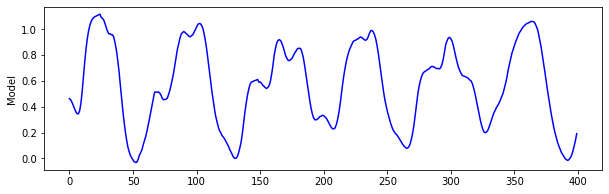

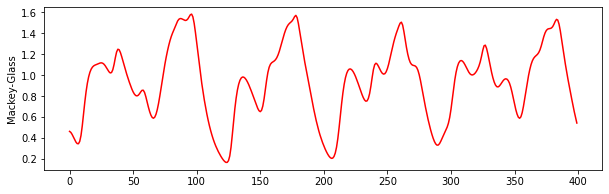

In [17]:
#iterate over a longer timeseries to see how well the model captures the dynamics
predict_time = 400
X = np.zeros(predict_time)
X[0:predict_length] = mg[0:predict_length]  #initial conditions
for t in range(predict_length,predict_time):
  inp = np.reshape(X[t-predict_length:t], newshape=(1,predict_length,1))
  X[t] = model.predict(inp)[0]

plt.figure(figsize=(10,3),linewidth=1)
plt.plot(X,'b')
plt.ylabel('Model')
plt.figure(figsize=(10,3),linewidth=1)
plt.plot(mg[0:predict_time],'r')
plt.ylabel('Mackey-Glass')
plt.show()

The model captures some of the near-periodicity of the original, and it definitely appears chaotic.  But notice that the nonlinear nature of the model and the small errors can introduce high-frequency noise that sometimes can grow rapidly.  This is an example of a positive Lyapunov exponent causing exponential divergence along one dimension (frequency band) in the space of functions.

In a sense this is good, because it means that the network has in fact learned a chaotic dynamical system, although not exactly the Mackey-Glass equation.

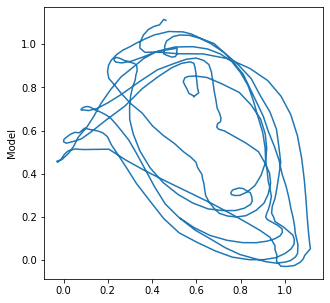

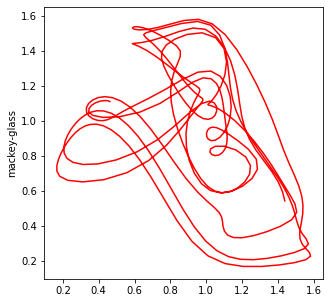

In [18]:
#compare the 2D embeddings for x[t] vs. x[t+1]
plt.figure(figsize=(5,5))
plt.plot(X[:len(X)-23],X[23:])
plt.ylabel('Model')
plt.figure(figsize=(5,5))
plt.plot(mg[:predict_time-23],mg[23:predict_time],'r')
plt.ylabel('mackey-glass');

In [41]:
#look at the function calculated by mackey-glass.
#   depends only on x[t] and x[t-23]
def mackey_glass_func(x0, x23, a=0.2, b=0.8, c=0.9, d=23, e=10):
    d = int(d)
    x  = c*x0 + ( (a*x23) / (b + ( x23**e)) )   
    return x

x = y = np.arange(mg.min(), mg.max(), 0.05)
X, Y = np.meshgrid(x, y)
zs = np.array(mackey_glass_func(np.ravel(X), np.ravel(Y)))
Z = zs.reshape(X.shape)



In [42]:
#compare to the same function computed by the network
#  note that the network does not use only x[t] and x[t-23]
npoints = len(np.ravel(X))
zs = np.zeros(npoints)
batch = np.zeros(predict_length)
for n in range(0,npoints):
  batch[predict_length-1] = np.ravel(X)[n]
  batch[predict_length-24] = np.ravel(Y)[n]
  c_batch = batch.reshape((1, predict_length, 1))
  zs[n] = model.predict(c_batch)[0]
Zm = zs.reshape(X.shape)



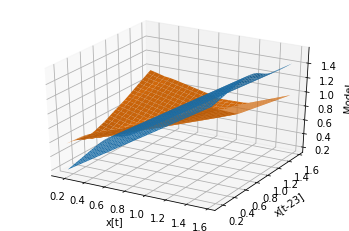

In [43]:
#plot the two.  they are not at the same scale
fig = plt.figure()
ax = fig.add_subplot(111, projection='3d')

ax.plot_surface(X, Y, Z)
ax.plot_surface(X,Y,3*Zm)
ax.set_xlabel('x[t]')
ax.set_ylabel('x[t-23]')
ax.set_zlabel('Model')

plt.show()